# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

# Часть 1

В данном задании вам необходимо **самостоятельно** реализовать один из алгоритмов кластеризации.  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).  
В классе помимо `__init__()` нужно реализовать два метода:
 - `fit()` - метод, выполняющий кластеризацию данных.
 - `predict()` - метод, определяющий для нового объекта, к какому из кластеров он относится. 
 
Для удобства можно создавать дополнительные методы класса, которые будут вызываться в `fit()` или `predict()`.  <br>
Функции для вычисления расстояний *между объектами* самим реализовывать не нужно, используйте реализации из `scipy`.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClusterMixin
from queue import Queue
from scipy.spatial import distance

import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
class My_Clust(BaseEstimator, ClusterMixin):
    """
    My implementation of clustering algorithm  
    """
    
    def __init__(self,
                 eps: float = 0.5,
                 min_samples: int = 5,
                 metric = 'euclidean',
                 metric_params = None,
                 **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.matrix = None
        self.metric_params = metric_params
                
        self.core_sample_indices_ = []  # [n_core_samples]
        self.labels_ = []  # [n_samples]
        self.core_sample_coords_ = []  # [n_core_samples, n_features]

    
    def get_distance(self, XA_index, XB_index, X):
        XA = X[XA_index]
        XB = X[XB_index]
        
        if callable(self.metric):
            # параметр additional используется в некоторых функциях расстояния
            # например, некоторые функции могут иметь веса или матрицы ковариация и т.п.
            return self.metric(XA, XB, self.metric_params)
        else:
            return self.matrix[XA_index][XB_index]
            # выбираем [i][j] расстояние

    
    def nearest_neighbors(self, point_id, radius, X):
        neighbors = []
        for i in range(len(X)):
            dist = self.get_distance(i, point_id, X)
            if dist <= radius:  # если расстояние меньше заданного
                neighbors.append(i)  # то это сосед, запишем его индекс
        return neighbors

        
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        X = pd.DataFrame(X).to_numpy()  # избавимся от разносортности данных
        
        # построим матрицу расстояний
        if self.metric_params is not None:
            p=self.metric_params['p']
            w=self.metric_params['w']
            V=self.metric_params['V']
            VI=self.metric_params['VI']
            out=self.metric_params['out']
        else:
            p, w, V, VI, out = None, None, None, None, None
        
        if type(self.metric) is str:  # если названа метрика расстояний
            self.matrix = distance.cdist(X, X, self.metric, p=p, w=w, V=V, VI=VI, out=out)  # то строим матрицу расстояний
        else:  # если дана матрица расстояний
            self.matrix = self.metric  # то переобозначаем матрицу как данную
        
        # введём некоторые обозначения
        noise = -1  # шумы
        core = -2  # опорные
        reachable = -3  # достижимые или граничные
        
        # этот список будет хранить статусы точек
        self.labels_ = [noise] * len(X)
        
        # запишем ближайших соседей для каждой точки
        neighborhoods = []
        for i in range(len(X)):
            neighborhoods.append(self.nearest_neighbors(i, self.eps, X))
            
        # списки опорных и остальных (core and reachable + noise) точек
        self.core_sample_indices_ = []
        self.noncore_sample_indices_ = []
                
        for i in range(len(neighborhoods)):
            if len(neighborhoods[i]) >= self.min_samples:  # если у точки нужное или большее число соседей (включая себя)
                self.labels_[i] = core  # то точка - опорная
                self.core_sample_coords_.append(X[i])
                self.core_sample_indices_.append(i)  # записали индекс этой точки в список опорных
            else:
                self.noncore_sample_indices_.append(i)  # иначе это не-опорная точка
                
        # пройдёмся по не-опорным точкам
        for i in self.noncore_sample_indices_:
            for j in neighborhoods[i]: # пройдёмся по соседям не-опорной точки
                if j in self.core_sample_indices_:  # если у i-ой точки соседняя j-ая точка является опорной
                    self.labels_[i] = reachable  # то она (i-ая) считается достижимой
                    break  # достаточно одного опорного соседа, чтобы считатться достижимой
        
        # будем использовать очередь для хранения соседних опорных точек для нахождения их соседей
        # cluster - метка класса, она будет меняться по ходу работы алгоритма
        cluster = 0
                        
        for i in range(len(self.labels_)):
            q = Queue()
            if self.labels_[i] == core:  # если точка опорная
                self.labels_[i] = cluster  # то запишем её в текущий кластер (проставим метку текущего кластера)
                for pt_idx in neighborhoods[i]:  # просмотрим соседние точки
                    if self.labels_[pt_idx] == core:  # если соседняя точка опорная
                        q.put(pt_idx)  # то запомним её (потом понадобится)
                        self.labels_[pt_idx] = cluster  # и занесём в текущий кластер
                    elif self.labels_[pt_idx] == reachable:
                        self.labels_[pt_idx] = cluster  # достижимые точки заносим в кластер, но не сохраняем в очередь
                # теперь пройдём по сохранённым основным точкам-соседям
                while not q.empty():
                    neighbors = neighborhoods[q.get()]  # найдём соседей точки
                    # и повторим то же самое, что и раньше
                    for pt_idx in neighbors:
                        if self.labels_[pt_idx] == core:
                            q.put(pt_idx)
                            self.labels_[pt_idx] = cluster
                        elif self.labels_[pt_idx] == reachable:
                            self.labels_[pt_idx] = cluster
                    # опорная точка -> её опорные соседи. и так для каждой опорной точки
                cluster += 1  # переход к следующему кластеру, когда закончим с опорными соседями
        # очередь позволяет отделять одну группу точек от другой - как только очередь заканчивается, заканчивается одна группа, одно "облако" и т.п.
        return self
    
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        labels = []  # [new_x_len]
        x = pd.DataFrame(x).to_numpy()
        for i in range(len(x)):
            neighbors = self.nearest_neighbors(i, self.eps, self.core_sample_coords_)  # записали индексы core-соседей
            labels_of_neighbors = [self.labels_[j] + 1 for j in neighbors]
            # т.к. bincount строит массив повторяемости с использованием чисел как индексов,
            # то нужно избавиться от лейблов = -1. для этого мы будем прибавлять 1 ко всем лейблам,
            # а затем вычтем 1
            labels.append(np.bincount(labels_of_neighbors).argmax() - 1)
            # записали тот кластер, в котором у точки больше всего core-соседей
        
        return labels
        
    
    def fit_predict(self, x, y=None):
        return self.fit(x, y).labels_

Пример использования матрицы расстояния:

In [3]:
data = [[5, 7], [7, 3], [8, 1]]
ctys = ['Boston', 'Phoenix', 'New York']
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=ctys)

dists = pd.DataFrame(distance.cdist(df.values, df.values), index=df.index, columns=df.index)

dists.loc['Boston', 'Phoenix']

4.47213595499958

### Вариант №1  

Алгоритм агломеративной кластеризации.  
  
Параметры: 
- **metric:** Функция расстояния между объектами. Должны поддерживаться метрики из `scipy.spatial.distance`, самописные функции (callable) и предрассчитанная матрица расстояний.  
- **linkage:** Расстояние между кластерами. Должны поддерживаться Single, Complete и Average.  
- **n_clusters:** Число кластеров. По умолчанию должно быть None. 

  
Атрибуты:  
- **z_:** матрица объединений, аналогичная той, что возвращает `linkage()` из `scipy.cluster.hierarchy`;
- **data_:** копия данных, использованных для кластеризации;  
- **labels_:** метки кластеров для каждого объекта.   
  
Дополнительно нужно реализовать метод `get_labels()` для вычисления **labels_**, он должен быть аналогичен [fcluster()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html). <br>
В случае, если **n_clusters** не None, то после вычисления матрицы **z_** в методе `fit()` должен быть вызван `get_labels()` с соответствующими параметрами, и вычислены **labels_**. В других случаях метод `fit()` только вычисляет матрицу **z_**, для вычисления **labels_** нужно явно вызывать `get_labels()`. 
  
Метод `predict()`:  Кластер для нового объекта определяется по методу, заданному в **linkage**.  <br>
**Note:** Метод `predict()` не выполняется в случае, когда **metric** - это матрица расстояний.

### Вариант №2

Алгоритм Dbscan.  
  
Параметры: 
- **eps:** радиус окрестности $\varepsilon$;  
- **min_samples:** минимальное число объектов в окрестности $\varepsilon$ для основных точек;  
- **metric:** функция расстояния между объектами. Должны поддерживаться метрики из `scipy.spatial.distance`, самописные функции (callable) и предрассчитанная матрица расстояний.   
- **metric_params:** параметры функции расстояния, если такие есть. 
  
Атрибуты:  
- **core\_sample\_coords\_:** - векторы основных точек;
- **labels_:** метки кластеров для каждого объекта.
  
Метод `predict()`:  Для нового объекта вычисляется число основных точек из каждого кластера, попавших в окрестность $\varepsilon$. Объект определяется в кластер с наибольшим числом таких точек.  
**Note:** Метод `predict()` не выполняется в случае, когда **metric** - это матрица расстояний. 

### Вариант №3

Алгоритм K-Means.  
  
Параметры: 
- **k:** число центров (кластеров);
- **init**: метод инициализации центров - random или kmeans++;
- **n_init**: число запусков алгоритма;
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Атрибуты:  
- **inertia_:** Итоговое значение целевой функции;
- **cluster\_centers\_:** центры кластеров - ndarray of shape (n_clusters, n_features);
- **labels_:** метки кластеров для каждого объекта.  
  
Метод `predict()`:  Новый объект определяется в кластер, центр которого расположен ближе всех к этому объекту. 

### Тестирование 

Вашу реализацию необходимо сравнить с питоновской реализацией алгоритма из `sklearn` или `scipy`. Результаты кластеризации должны совпадать.  
Также необходимо сравнить скорость работы вашей реализации и питоновской (это нормально, если ваша реализация будет медленнее).  
Сравнение необходимо выполнить на наборе данных iris.

In [4]:
nums = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80]])

clustering_my = My_Clust(eps=3, min_samples=2).fit_predict(nums)
print(clustering_my)

clustering_db = DBSCAN(eps=3, min_samples=2).fit_predict(nums)
print(clustering_db)

adjusted_rand_score(clustering_my, clustering_db)

[0, 0, 0, 1, 1, -1]
[ 0  0  0  1  1 -1]


1.0

In [5]:
iris = load_iris()
X = iris.data # использовать для кластеризации
y = iris.target # истинные метки цветков

In [6]:
X = pd.DataFrame(X, columns=iris.feature_names)
X_all = X.copy()
X_all['class'] = [iris.target_names[i] for i in y]

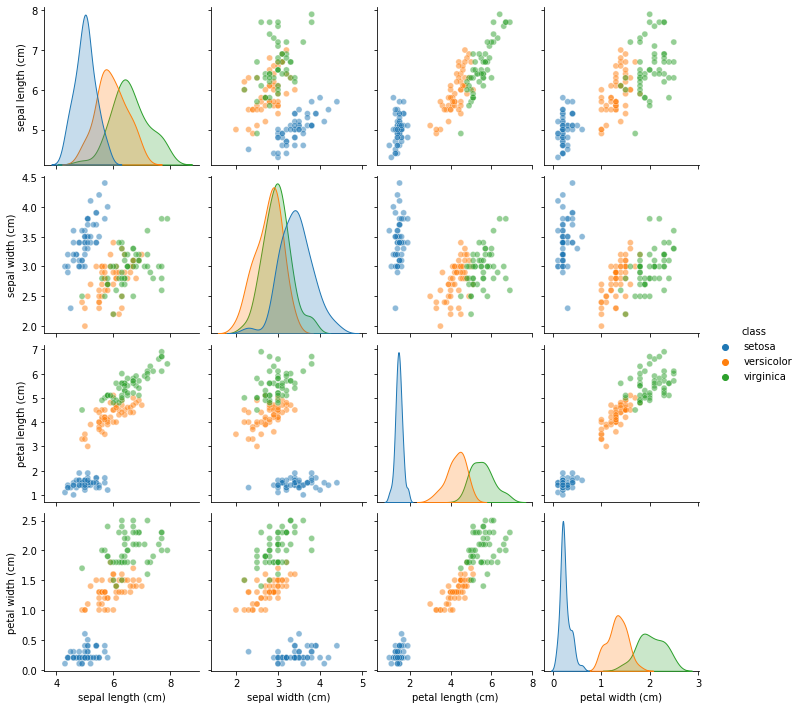

In [7]:
sns.pairplot(X_all, hue='class', plot_kws={'alpha':0.5}, vars=iris.feature_names)
plt.show()

Как можно видеть, ARI равен 1 => алгоритмы работают одинаково

In [8]:
from time import time

In [9]:
t = time()
clust_db = DBSCAN(eps=0.4, min_samples=3).fit_predict(X)
print('Time:', time() - t, 'seconds')
print(clust_db)
adjusted_rand_score(clust_db, y)

Time: 0.011994123458862305 seconds
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  2  1  1  2  1 -1  1 -1  1  1  1 -1  1  3  1
  3  1  1  1  1  1  1  1  1  1  1  3  1  1  1 -1  1  1  1  1  1  2  1  1
  1  1  2  1 -1  3  3  3  3 -1 -1 -1 -1 -1  3  3  3  3 -1  3  3 -1 -1 -1
  3  3 -1  3  3  3  3  3  3  3 -1 -1  3  3 -1 -1  3  3  3  3  3  3  3  3
  3  3  3  3  3  3]


0.7063013754344988

In [10]:
t = time()
clust_my = My_Clust(eps=0.4, min_samples=3).fit_predict(X)
print('Time:', time() - t, 'seconds')
print(clust_my)
adjusted_rand_score(clust_my, y)

Time: 0.06399798393249512 seconds
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, -1, 1, -1, 1, 1, 1, -1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, -1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, -1, 3, 3, 3, 3, -1, -1, -1, -1, -1, 3, 3, 3, 3, -1, 3, 3, -1, -1, -1, 3, 3, -1, 3, 3, 3, 3, 3, 3, 3, -1, -1, 3, 3, -1, -1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


0.7063013754344988

In [11]:
adjusted_rand_score(clust_db, clust_my)

1.0

Проверим, как работает механика предсказания. Пусть нам пришли данные, идентичные некоторым строчкам. Результат предсказаний должен совпадать с соответсвующими ярлыками кластеров

In [12]:
X

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]

In [13]:
new_X = X[0:10:2]
new_X

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
2                4.7               3.2                1.3               0.2
4                5.0               3.6                1.4               0.2
6                4.6               3.4                1.4               0.3
8                4.4               2.9                1.4               0.2

In [14]:
cl = My_Clust(eps=0.4, min_samples=3).fit(X)

In [15]:
print(cl.labels_[0:10:2])

[0, 0, 0, 0, 0]


In [16]:
cl.predict(new_X)

[0, 0, 0, 0, 0]

Как можно видеть, лейблы действительно совпадают, а значит механика предсказания работает корректно

### Бонусное  
  
Дополнительно вы можете поработать над эффективностью алгоритма по скорости и памяти, добавить поддержку многопоточности, или расширить базовый функционал.

### Распределение по вариантам

In [17]:
pd.set_option('display.max_rows', 50)

In [18]:
Vars = pd.read_csv('Vars.txt', sep='\t')

#### Вариант №1

In [19]:
Vars[Vars.iloc[:,2] == 1]

ФИО Группа  Вариант №
0             Бакурский Андрей Сергеевич  1 ИАД          1
2              Бекина Светлана Сергеевна  1 ИАД          1
3           Бекусов Михаил Александрович  1 ИАД          1
9              Конина Татьяна Дмитриевна  1 ИАД          1
11         Лукичева Полина Александровна  1 ИАД          1
12          Моничева Арина Александровна  1 ИАД          1
22                 Трухин Егор Сергеевич  1 ИАД          1
23         Шарунов Евгений Александрович  1 ИАД          1
24             Шатилов Виктор Алексеевич  1 ИАД          1
27         Астахова Елизавета Евгеньевна  2 ИАД          1
29              Баранов Денис Алексеевич  2 ИАД          1
30  Баховаддинов Искандар Худайбердиевич  2 ИАД          1
34             Казюлина Марина Сергеевна  2 ИАД          1
35            Карабасова Юлия Алексеевна  2 ИАД          1
38      Меркулова Екатерина Владимировна  2 ИАД          1
40                Сазанов Илья Денисович  2 ИАД          1
45           Тормашова Валерия Сергеевна  2 ИАД          1
47               Федоров Макар Андреевич  2 ИАД          1
50          Шешменева Кристина Сергеевна  2 ИАД          1
53                  Артюх Майя Сергеевна  3 ИАД          1
59              Лашина Надежда Андреевна  3 ИАД          1
61            Рябинина Полина Викторовна  3 ИАД          1
63           Харинский Дмитрий Сергеевич  3 ИАД          1

#### Вариант №2

In [20]:
Vars[Vars.iloc[:,2] == 2]

ФИО Группа  Вариант №
1            Балаян Роман Каренович  1 ИАД          2
5            Даняев Артем Андреевич  1 ИАД          2
7           Ешманов Павел Андреевич  1 ИАД          2
10           Костин Андрей Олегович  1 ИАД          2
15      Ожиганова Полина Максимовна  1 ИАД          2
17     Сапожников Андрей Михайлович  1 ИАД          2
18            Семаев Никита Юрьевич  1 ИАД          2
21          Суворов Артём Андреевич  1 ИАД          2
25       Южаков Максим Вячеславович  1 ИАД          2
28        Бабий Александр Сергеевич  2 ИАД          2
32        Гаранина Мария Евгеньевна  2 ИАД          2
33   Гаращенкова Анна Александровна  2 ИАД          2
36      Корякин Владислав Андреевич  2 ИАД          2
39           Мушка Никита Андреевич  2 ИАД          2
42          Соколова Анна Ильинична  2 ИАД          2
43  Солдаткин Константин Алексеевич  2 ИАД          2
48   Харханова Екатерина Михайловна  2 ИАД          2
51             Шувар Алена Олеговна  2 ИАД          2
55        Дудин Григорий Алексеевич  3 ИАД          2
56        Егоров Николай Михайлович  3 ИАД          2
58        Кучеренко Анна Васильевна  3 ИАД          2
60          Матвеева Дарья Игоревна  3 ИАД          2
64     Частова Екатерина Робертовна  3 ИАД          2
67         Шемет Савелий Кириллович  3 ИАД          2

#### Вариант №3

In [21]:
Vars[Vars.iloc[:,2] == 3]

ФИО Группа  Вариант №
4             Боряев Сергей Сергеевич  1 ИАД          3
6         Дыряев Даниил Александрович  1 ИАД          3
8         Игумнова Наталья Дмитриевна  1 ИАД          3
13          Мурзинов Михаил Денисович  1 ИАД          3
14           Николаева Олеся Игоревна  1 ИАД          3
16            Османов Ислам Рамилевич  1 ИАД          3
19         Смирнов Григорий Андреевич  1 ИАД          3
20        Стифеев Никита Владимирович  1 ИАД          3
26      Арбузова Екатерина Михайловна  2 ИАД          3
31       Варгин Дмитрий Александрович  2 ИАД          3
37               Левин Глеб Сергеевич  2 ИАД          3
41         Смирнов Дмитрий Викторович  2 ИАД          3
44      Терентьева Анастасия Олеговна  2 ИАД          3
46            Точкова Арина Андреевна  2 ИАД          3
49           Шарапов Максим Сергеевич  2 ИАД          3
52           Юдакова Олеся Валерьевна  2 ИАД          3
54          Басыров Андрей Дмитриевич  3 ИАД          3
57  Закареишвили Гиоргий Годердзиевич  3 ИАД          3
62           Семенова Елена Андреевна  3 ИАД          3
65         Чернов Роман Александрович  3 ИАД          3
66       Шауклис Александр Николаевич  3 ИАД          3

# Часть 2

В данном задании вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

In [22]:
pd.set_option('display.max_colwidth', None)

In [23]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

Attribute  \
0                       Place   
1           Climate & Terrain   
2                     Housing   
3   Health Care & Environment   
4                       Crime   
5              Transportation   
6                   Education   
7                    The Arts   
8                  Recreation   
9                   Economics   
10                  Longitude   
11                   Latitude   
12                 Population   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                          City, state (postal code)  
1                                                                                                                                                                                                                                                                                                                              Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days.  
2                                                                                                                                                                                                                                                                                                                                                                                                                                  Utility bills, property taxes, mortgage payments.  
3                                                                                                                                                                                                                                                Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution.  
4                                                                                                                                                                                                                                                                                                                                                                                                                                           Violent crime rate, property crime rate.  
5                                                                                                                                                                                                                                                                                                                                                                                    Daily commute, public transportation, Interstate highways, air service, passenger rail service.  
6                                                                                                                                                                                                                                                                   

### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [24]:
data = pd.read_csv('Data.txt', sep=' ')
data

Place  Climate  HousingCost  HlthCare  Crime  \
0                    Abilene,TX      521         6200       237    923   
1                      Akron,OH      575         8138      1656    886   
2                     Albany,GA      468         7339       618    970   
3    Albany-Schenectady-Troy,NY      476         7908      1431    610   
4                Albuquerque,NM      659         8393      1853   1483   
..                          ...      ...          ...       ...    ...   
324                Worcester,MA      562         8715      1805    680   
325                   Yakima,WA      535         6440       317   1106   
326                     York,PA      540         8371       713    440   
327        Youngstown-Warren,OH      570         7021      1097    938   
328                Yuba-City,CA      608         7875       212   1179   

     Transp  Educ  Arts  Recreat  Econ      Long      Lat     Pop  
0      4031  2757   996     1405  7633  -99.6890  32.5590  110932  
1      4883  2438  5564     2632  4350  -81.5180  41.0850  660328  
2      2531  2560   237      859  5250  -84.1580  31.5750  112402  
3      6883  3399  4655     1617  5864  -73.7983  42.7327  835880  
4      6558  3026  4496     2612  5727 -106.6500  35.0830  419700  
..      ...   ...   ...      ...   ...       ...      ...     ...  
324    3643  3299  1784      910  5040  -71.7950  42.2720  402918  
325    3731  2491   996     2140  4986 -120.5130  46.5950  172508  
326    2267  2903  1022      842  4946  -76.7280  39.9600  381255  
327    3374  2920  2797     1327  3894  -80.7290  41.1700  531350  
328    2768  2387   122      918  4694 -121.6220  39.1280  101979  

[329 rows x 13 columns]

<br>  
  
## Задания: 

1. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.  

In [25]:
data_dropped = data.drop(labels=['Place', 'Long', 'Lat'], axis=1)
data_dropped

Climate  HousingCost  HlthCare  Crime  Transp  Educ  Arts  Recreat  Econ  \
0        521         6200       237    923    4031  2757   996     1405  7633   
1        575         8138      1656    886    4883  2438  5564     2632  4350   
2        468         7339       618    970    2531  2560   237      859  5250   
3        476         7908      1431    610    6883  3399  4655     1617  5864   
4        659         8393      1853   1483    6558  3026  4496     2612  5727   
..       ...          ...       ...    ...     ...   ...   ...      ...   ...   
324      562         8715      1805    680    3643  3299  1784      910  5040   
325      535         6440       317   1106    3731  2491   996     2140  4986   
326      540         8371       713    440    2267  2903  1022      842  4946   
327      570         7021      1097    938    3374  2920  2797     1327  3894   
328      608         7875       212   1179    2768  2387   122      918  4694   

        Pop  
0    110932  
1    660328  
2    112402  
3    835880  
4    419700  
..      ...  
324  402918  
325  172508  
326  381255  
327  531350  
328  101979  

[329 rows x 10 columns]

In [26]:
data_dropped.isna().sum()

Climate        0
HousingCost    0
HlthCare       0
Crime          0
Transp         0
Educ           0
Arts           0
Recreat        0
Econ           0
Pop            0
dtype: int64

In [27]:
from sklearn.preprocessing import MinMaxScaler

data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data_dropped), columns=data_dropped.columns)
data_norm

Climate  HousingCost  HlthCare     Crime    Transp      Educ      Arts  \
0    0.516770     0.056328  0.024849  0.280822  0.385829  0.507692  0.016651   
1    0.583851     0.161193  0.206609  0.263927  0.499733  0.354327  0.097225   
2    0.450932     0.117959  0.073652  0.302283  0.185294  0.412981  0.003263   
3    0.460870     0.148747  0.177789  0.137900  0.767112  0.816346  0.081192   
4    0.688199     0.174991  0.231843  0.536530  0.723663  0.637019  0.078387   
..        ...          ...       ...       ...       ...       ...       ...   
324  0.567702     0.192414  0.225695  0.169863  0.333957  0.768269  0.030551   
325  0.534161     0.069314  0.035097  0.364384  0.345722  0.379808  0.016651   
326  0.540373     0.173800  0.085820  0.060274  0.150000  0.577885  0.017110   
327  0.577640     0.100752  0.135007  0.287671  0.297995  0.586058  0.048419   
328  0.624845     0.146962  0.021647  0.397717  0.216979  0.329808  0.001235   

      Recreat      Econ       Pop  
0    0.245556  0.661572  0.005859  
1    0.518222  0.188176  0.072759  
2    0.124222  0.317952  0.006038  
3    0.292667  0.406489  0.094136  
4    0.513778  0.386734  0.043458  
..        ...       ...       ...  
324  0.135556  0.287671  0.041414  
325  0.408889  0.279885  0.013357  
326  0.120444  0.274117  0.038776  
327  0.228222  0.122422  0.057053  
328  0.137333  0.237779  0.004768  

[329 rows x 10 columns]

2. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы. 

In [28]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

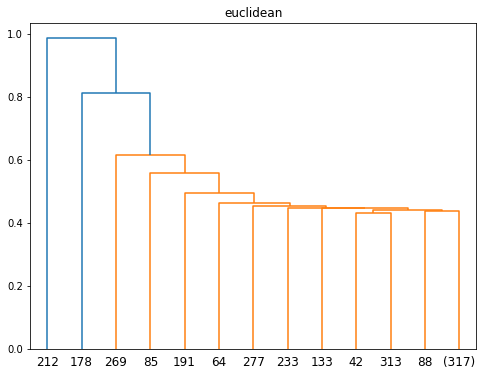

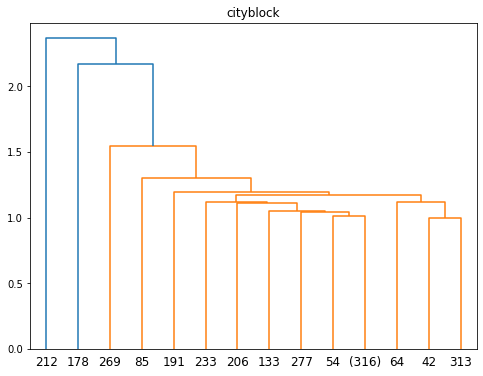

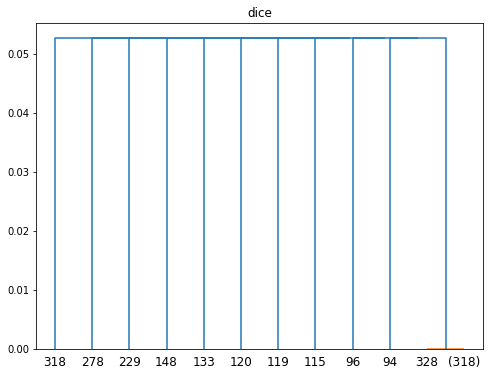

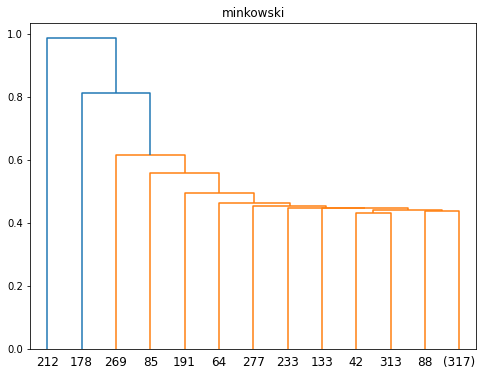

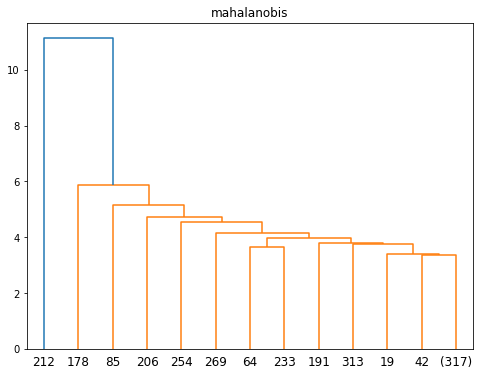

In [29]:
metrics = ['euclidean', 'cityblock', 'dice', 'minkowski', 'mahalanobis']

for metric in metrics:
    plt.figure(figsize=(8, 6))
    plt.title(metric)
    dendrogram(linkage(data_norm, metric=metric), truncate_mode='level', p=10)
    plt.show()

Можно видеть, что большинство метрик поступают одинаково. Поэтому пусть будем использовать классическую метрику расстояния Евклида

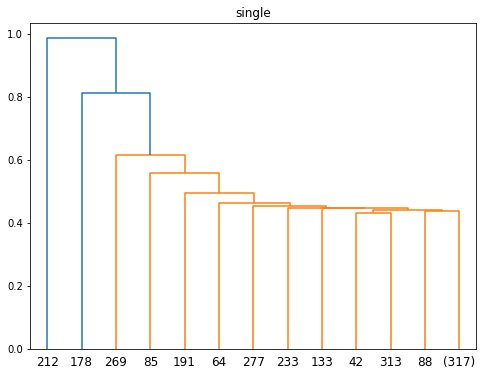

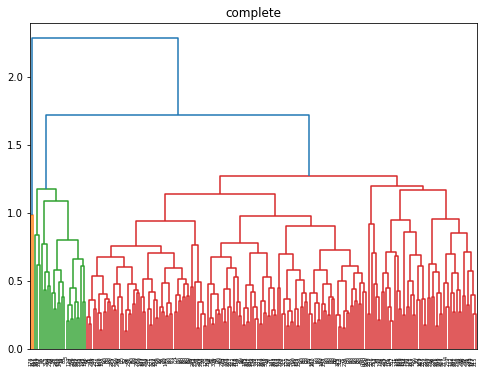

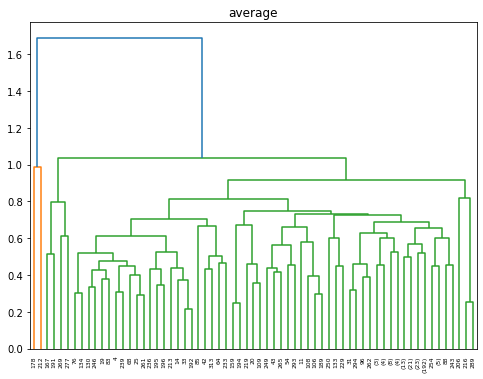

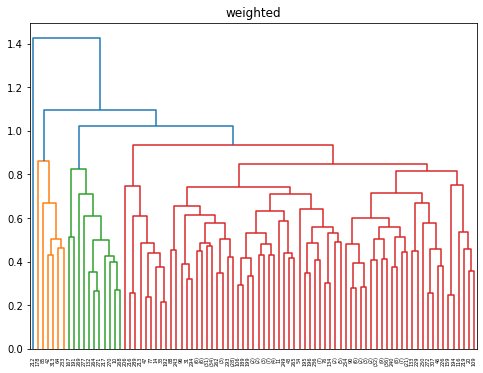

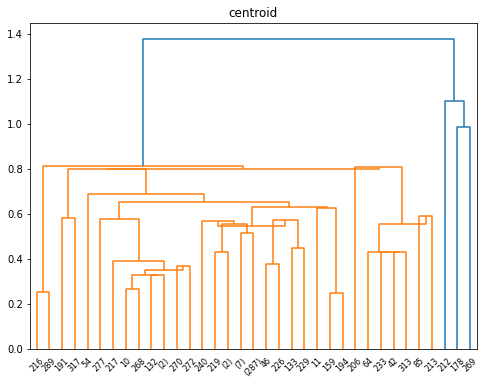

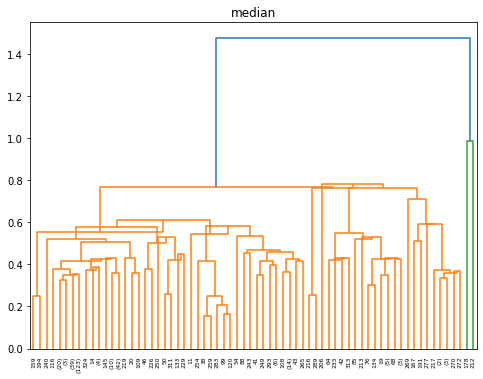

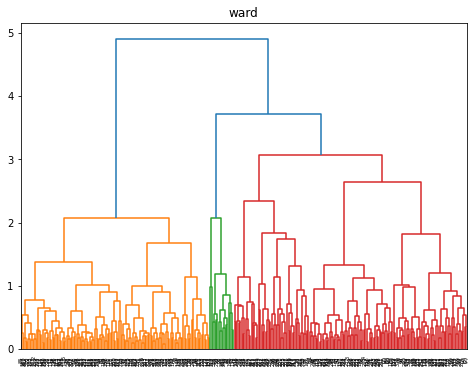

In [30]:
methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

for method in methods:
    plt.figure(figsize=(8, 6))
    plt.title(method)
    dendrogram(linkage(data_norm, metric='euclidean', method=method), truncate_mode='level', p=10)
    plt.show()

Тут методы дают совершенно разные варианты. Будем использовать ward-метод, т.к. есть хорошо выраженные расстояния между кластерами

In [31]:
agglomerative_clustering = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=4).fit(data_norm)

3. Выполните кластеризацию методом Dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.

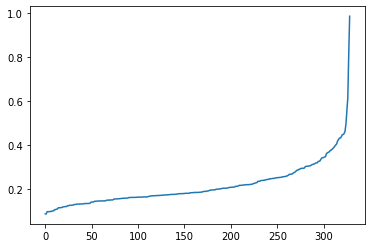

In [32]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(data_norm)
distances, indices = nbrs.kneighbors(data_norm)    

plt.plot(sorted(distances[:, -1]))
plt.show()

По методу каменистой осыпи (или локтя) можно определить, что оптимальным eps будет 0.35, а min_samples выставим 2

In [33]:
dbscan_clustering = DBSCAN(eps=0.35, min_samples=2, metric='euclidean').fit(data_norm)

4. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  


In [34]:
from sklearn.cluster import KMeans

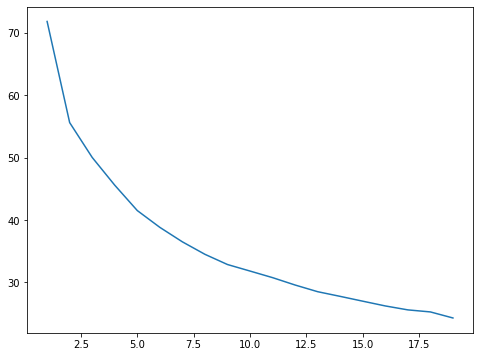

In [35]:
inertia = []

for i in range(1, 20):
    km = KMeans(n_clusters=i).fit(data_norm)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), inertia)

По методу локтя выберем число кластеров, равное 5

In [36]:
kmeans_clustering = KMeans(n_clusters=5).fit(data_norm)

5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.    

In [37]:
from sklearn.cluster import OPTICS

In [38]:
optics_clustering = OPTICS(min_samples=3, max_eps=0.15).fit(data_norm)
np.unique(optics_clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5])

6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиений объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).

In [39]:
clusterings = {'agglom': agglomerative_clustering,
               'dbscan': dbscan_clustering,
               'kmeans': kmeans_clustering,
               'optics': optics_clustering}

for clustering in clusterings.values():
    print(np.unique(clustering.labels_))

[0 1 2 3]
[-1  0  1  2]
[0 1 2 3 4]
[-1  0  1  2  3  4  5]


Как можно видеть, разные алгоритмы создают разное количество кластеров

Сравним алгоритмы по скорости обучения:

In [40]:
for name, clustering in clusterings.items():
    t = time()
    clustering.fit(data_norm)
    t = time() - t
    print(f'{name}. Time: {t}')

agglom. Time: 0.016002655029296875
dbscan. Time: 0.01999211311340332
kmeans. Time: 0.08800435066223145
optics. Time: 0.045150041580200195


На текущих данных получилось так, что AgglomerativeClustering самый быстрый алгоритм

In [41]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

In [42]:
for name, clustering in clusterings.items():
    print(name, silhouette_score(data_norm, clustering.labels_))

agglom 0.12768413551511812
dbscan 0.25663780344558
kmeans 0.15197252525557414
optics -0.301760601797722


По метрике силуэта получилось, что лучшую кластеризацию провёл DBSCAN

In [43]:
def clusters_stats(name, n_clusters, clusters, X):
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                  "with n_clusters = %d" % (name, n_clusters)),
                 fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 4 The average silhouette_score is : 0.12768413551511812


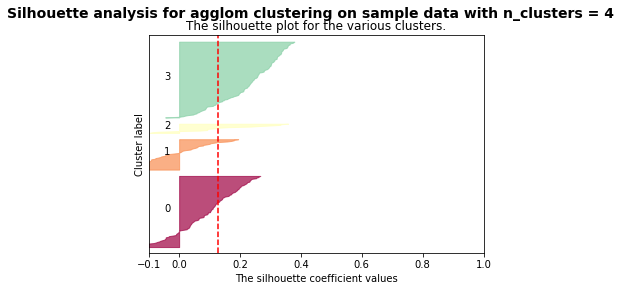

For n_clusters = 4 The average silhouette_score is : 0.25663780344558


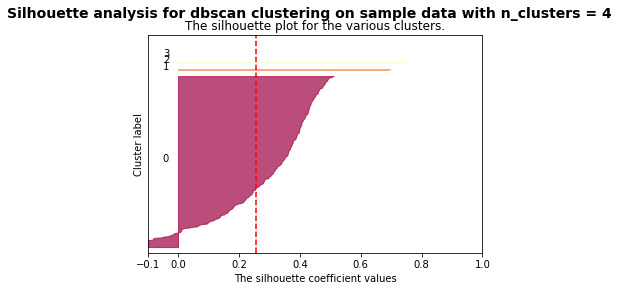

For n_clusters = 5 The average silhouette_score is : 0.15197252525557414


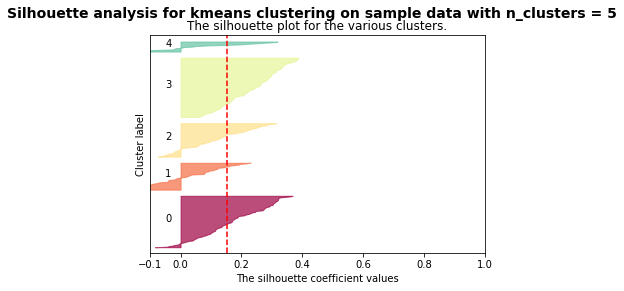

For n_clusters = 7 The average silhouette_score is : -0.301760601797722


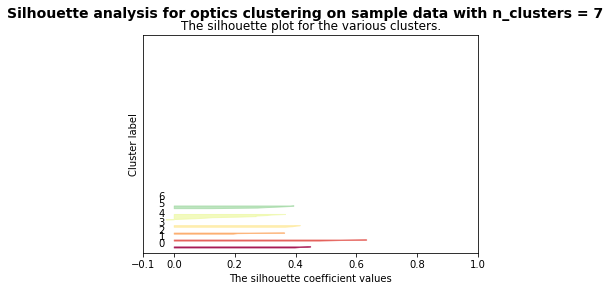

In [44]:
for name, clustering in clusterings.items():
    n_clusters = len(np.unique(clustering.labels_))
    clusters = clustering.labels_
    clusters_stats(name, n_clusters, clusters, data_norm)

Однако при рассмотрении визуализации силуэта видно, что лучше получилось у алгоритмов AgglomerativeClustering и KMeans

7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.

В качестве лучшего разбиения выберем AgglomerativeCLustering

In [45]:
data_norm

Climate  HousingCost  HlthCare     Crime    Transp      Educ      Arts  \
0    0.516770     0.056328  0.024849  0.280822  0.385829  0.507692  0.016651   
1    0.583851     0.161193  0.206609  0.263927  0.499733  0.354327  0.097225   
2    0.450932     0.117959  0.073652  0.302283  0.185294  0.412981  0.003263   
3    0.460870     0.148747  0.177789  0.137900  0.767112  0.816346  0.081192   
4    0.688199     0.174991  0.231843  0.536530  0.723663  0.637019  0.078387   
..        ...          ...       ...       ...       ...       ...       ...   
324  0.567702     0.192414  0.225695  0.169863  0.333957  0.768269  0.030551   
325  0.534161     0.069314  0.035097  0.364384  0.345722  0.379808  0.016651   
326  0.540373     0.173800  0.085820  0.060274  0.150000  0.577885  0.017110   
327  0.577640     0.100752  0.135007  0.287671  0.297995  0.586058  0.048419   
328  0.624845     0.146962  0.021647  0.397717  0.216979  0.329808  0.001235   

      Recreat      Econ       Pop  
0    0.245556  0.661572  0.005859  
1    0.518222  0.188176  0.072759  
2    0.124222  0.317952  0.006038  
3    0.292667  0.406489  0.094136  
4    0.513778  0.386734  0.043458  
..        ...       ...       ...  
324  0.135556  0.287671  0.041414  
325  0.408889  0.279885  0.013357  
326  0.120444  0.274117  0.038776  
327  0.228222  0.122422  0.057053  
328  0.137333  0.237779  0.004768  

[329 rows x 10 columns]

In [46]:
all_combinations = []

for col1 in data_norm.columns:
    for col2 in data_norm.columns:
        if (col1, col2) not in all_combinations and (col2, col1) not in all_combinations and col1 != col2:
            all_combinations.append((col1, col2))
            
all_combinations

[('Climate', 'HousingCost'),
 ('Climate', 'HlthCare'),
 ('Climate', 'Crime'),
 ('Climate', 'Transp'),
 ('Climate', 'Educ'),
 ('Climate', 'Arts'),
 ('Climate', 'Recreat'),
 ('Climate', 'Econ'),
 ('Climate', 'Pop'),
 ('HousingCost', 'HlthCare'),
 ('HousingCost', 'Crime'),
 ('HousingCost', 'Transp'),
 ('HousingCost', 'Educ'),
 ('HousingCost', 'Arts'),
 ('HousingCost', 'Recreat'),
 ('HousingCost', 'Econ'),
 ('HousingCost', 'Pop'),
 ('HlthCare', 'Crime'),
 ('HlthCare', 'Transp'),
 ('HlthCare', 'Educ'),
 ('HlthCare', 'Arts'),
 ('HlthCare', 'Recreat'),
 ('HlthCare', 'Econ'),
 ('HlthCare', 'Pop'),
 ('Crime', 'Transp'),
 ('Crime', 'Educ'),
 ('Crime', 'Arts'),
 ('Crime', 'Recreat'),
 ('Crime', 'Econ'),
 ('Crime', 'Pop'),
 ('Transp', 'Educ'),
 ('Transp', 'Arts'),
 ('Transp', 'Recreat'),
 ('Transp', 'Econ'),
 ('Transp', 'Pop'),
 ('Educ', 'Arts'),
 ('Educ', 'Recreat'),
 ('Educ', 'Econ'),
 ('Educ', 'Pop'),
 ('Arts', 'Recreat'),
 ('Arts', 'Econ'),
 ('Arts', 'Pop'),
 ('Recreat', 'Econ'),
 ('Recreat', 

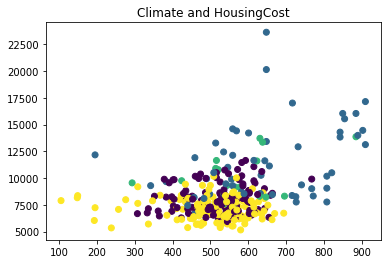

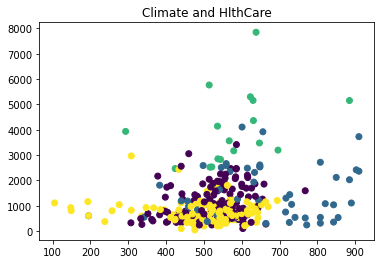

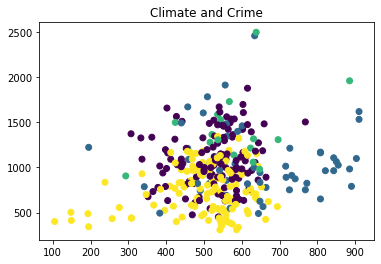

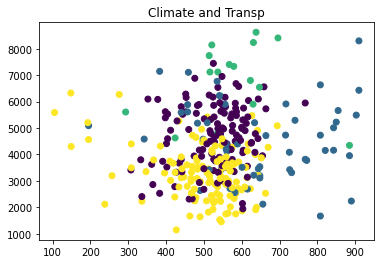

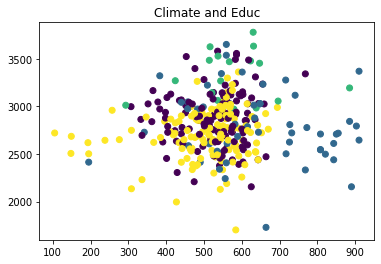

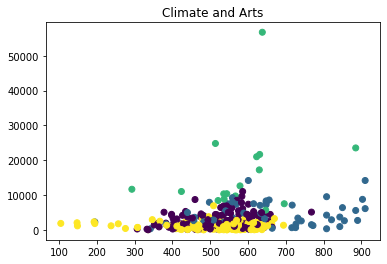

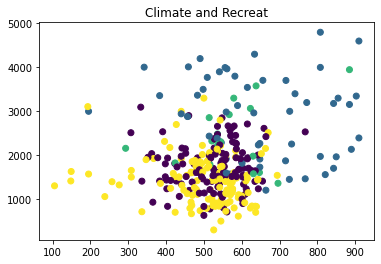

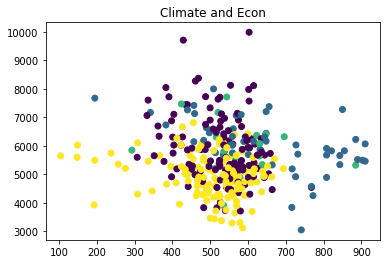

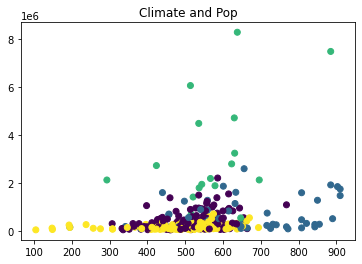

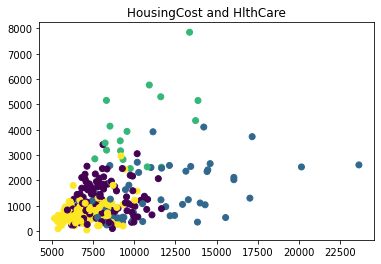

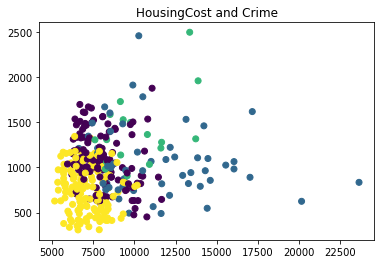

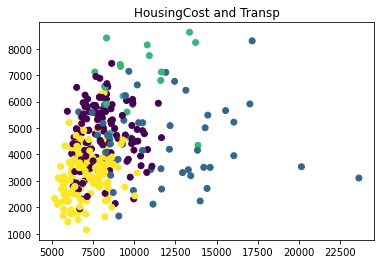

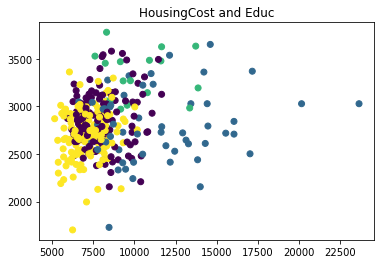

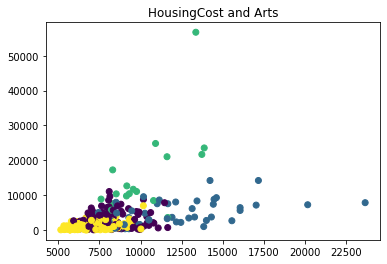

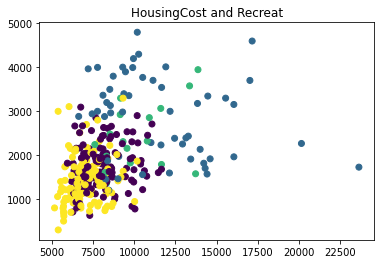

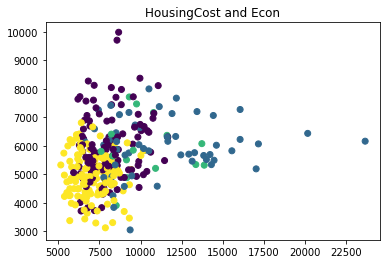

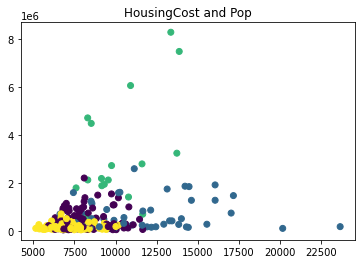

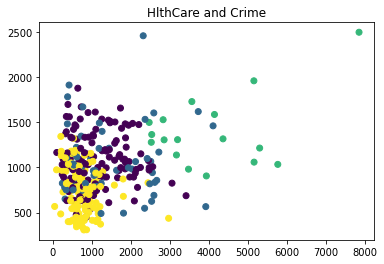

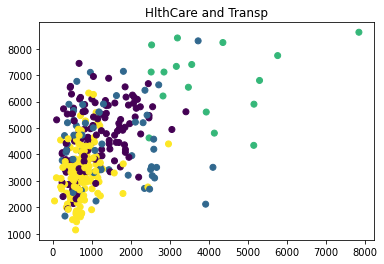

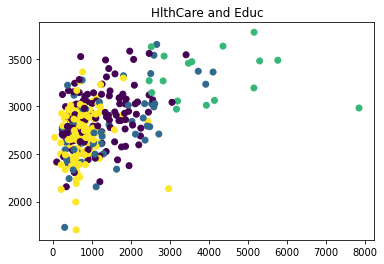

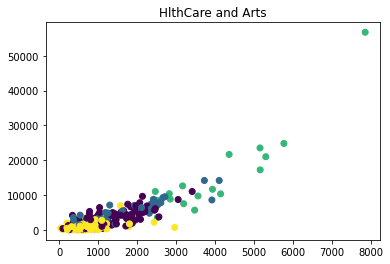

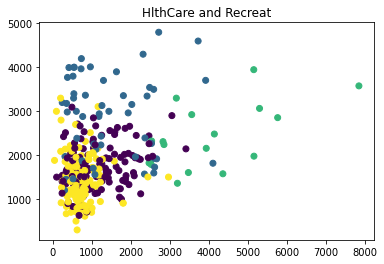

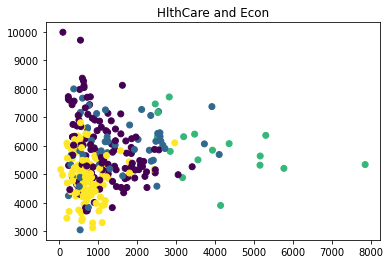

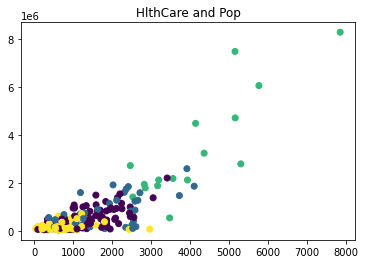

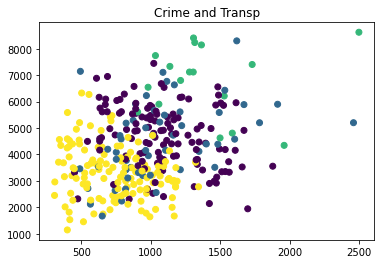

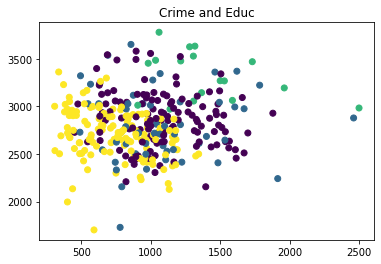

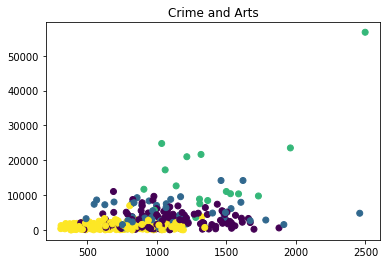

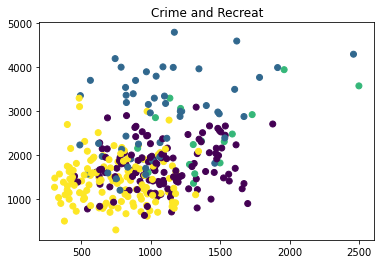

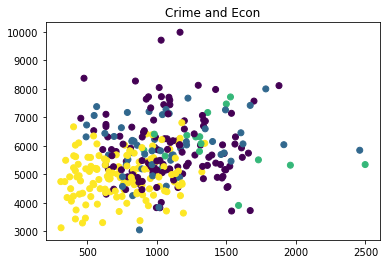

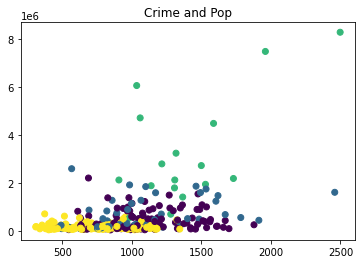

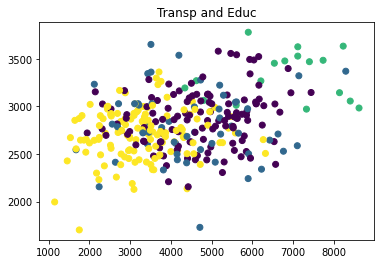

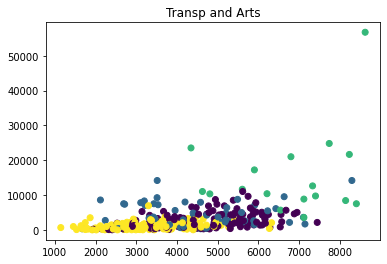

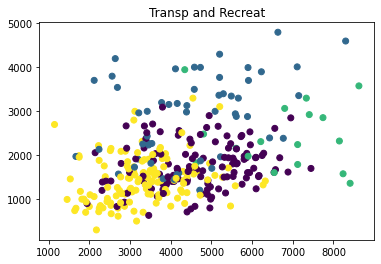

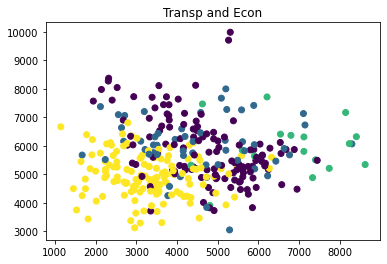

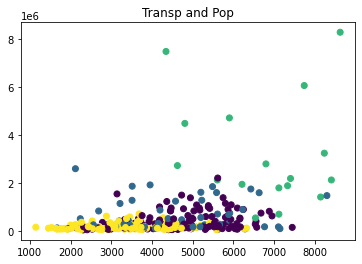

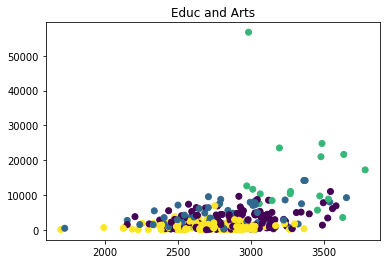

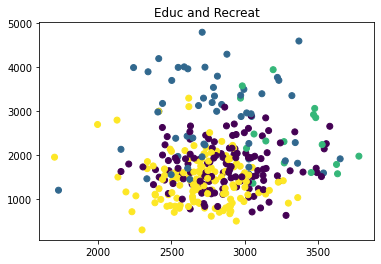

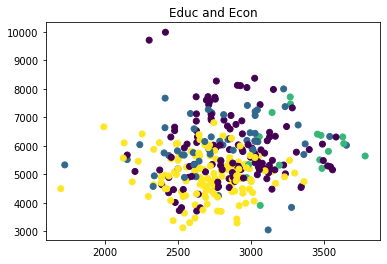

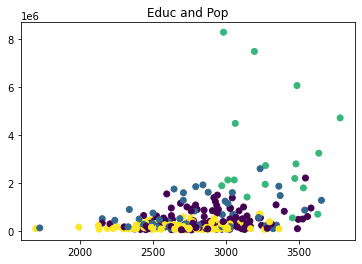

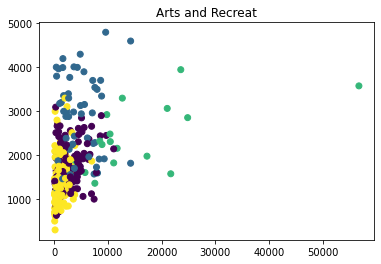

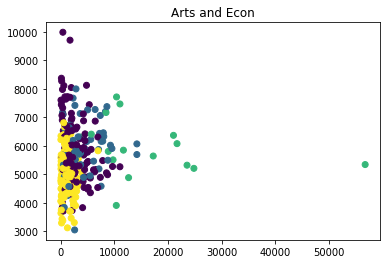

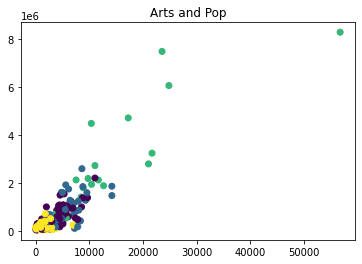

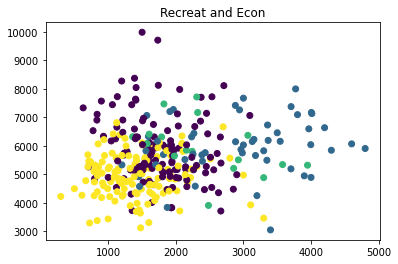

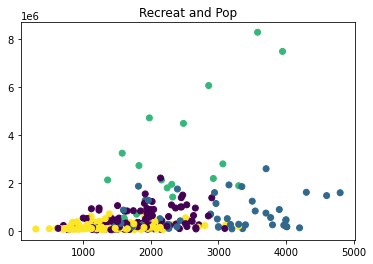

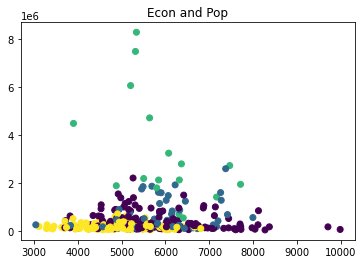

In [47]:
for col1, col2 in all_combinations:
    if col1 != col2:
        plt.title(f'{col1} and {col2}')
        plt.scatter(data[col1], data[col2], c=agglomerative_clustering.labels_)
        plt.show()

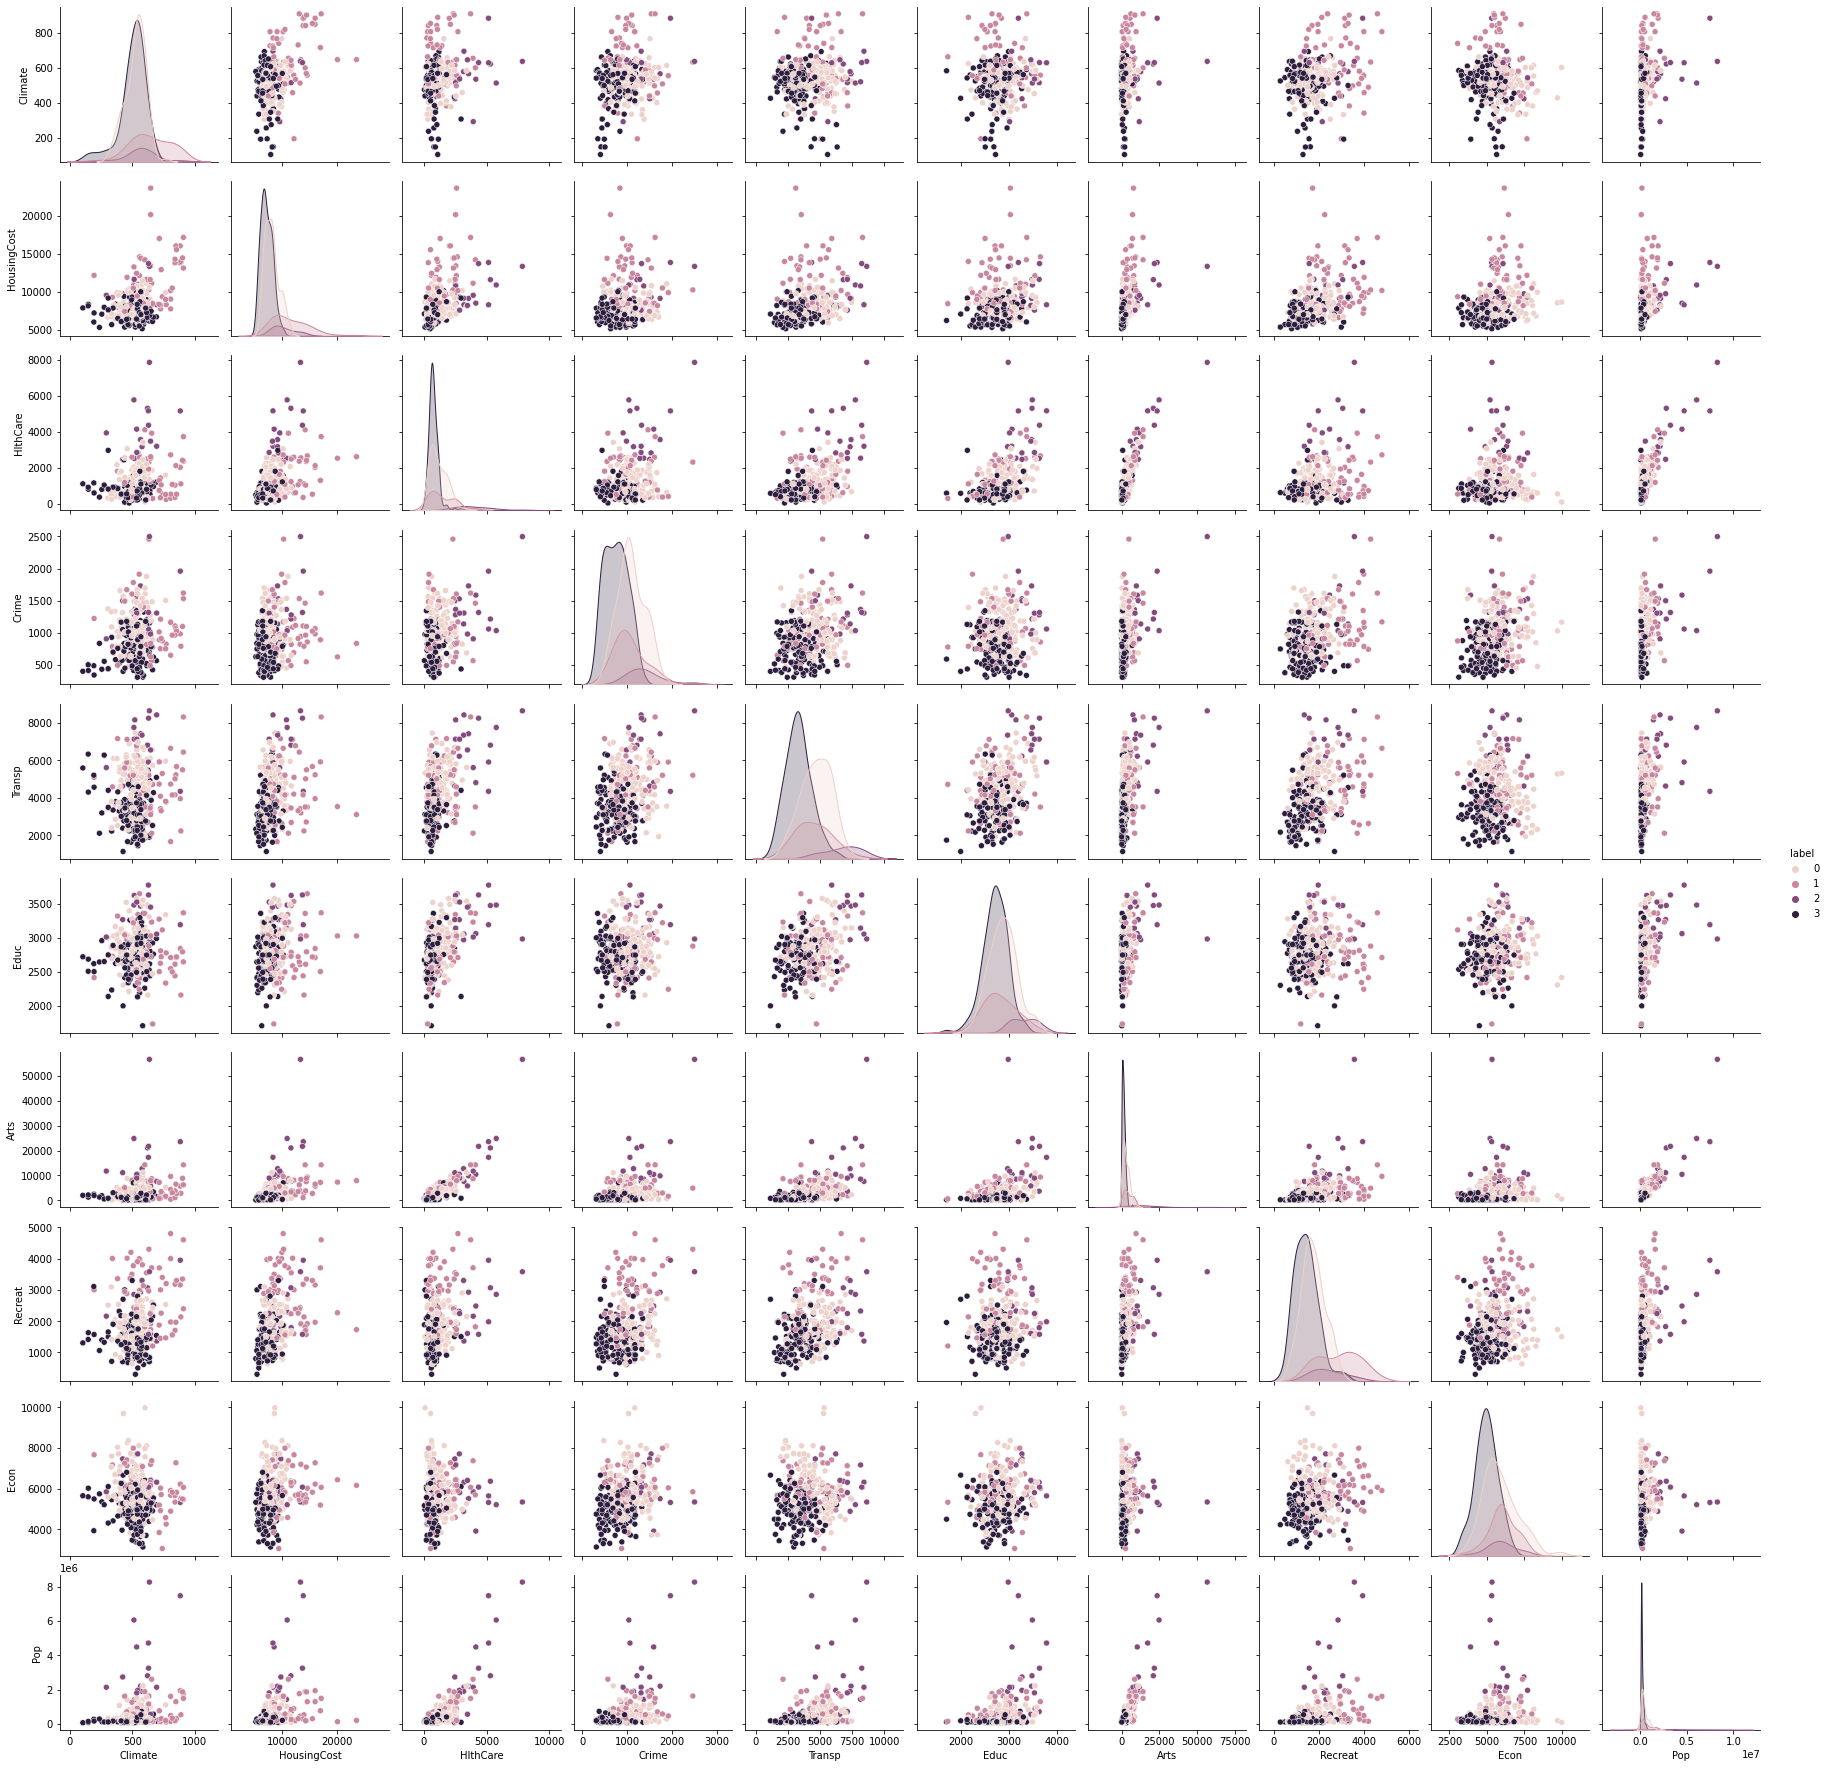

In [48]:
data_with_labels = data[data_norm.columns].copy()
data_with_labels['label'] = agglomerative_clustering.labels_
sns.pairplot(data=data_with_labels, hue='label')

Можно видеть, что многие точки, соответствующие одному кластеру, действительно группируются в определённые "кучки". Однако выделить хоть на каком-либо графике области, по которым можно визуально определить кластеры, нельзя, т.к. точки разных цветов сильно перемешаны.

In [49]:
from sklearn.manifold import TSNE

data_embedded = TSNE(n_components=2, random_state=42).fit_transform(data_norm)
data_embedded.shape

(329, 2)

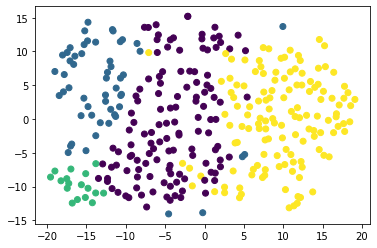

In [50]:
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=agglomerative_clustering.labels_)

Однако, согласно TSNE, кластеризация получилась вполне качественная, но определить "на глаз" скопления данных не получается

8. Оцените, как полученные кластеры распределены географически.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?  
(Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.

In [51]:
data_stated = data.copy()
data_stated['State'] = [x.split(',')[1] for x in data.Place]
print(data_stated.State.unique())
print(len(data_stated.State.unique()))
data_stated

['TX' 'OH' 'GA' 'NY' 'NM' 'LA' 'Bethlehem' 'Granite-City' 'PA' 'CA' 'AK'
 'IN' 'SC' 'MI' 'AL' 'WI' 'NC' 'NJ' 'GA-SC' 'IL' 'MD' 'ME' 'WA' 'MT' 'MS'
 'ND' 'ID' 'MA' 'CO' 'FL' 'CT' 'VT' 'WY' 'IA' 'WV' 'NC-SC' 'VA' 'TN-GA'
 'OH-KY-IN' 'TN-KY' 'MO' 'GA-AL' 'MD-WV' 'IA-IL' 'MN-WI' 'OK' 'OR' 'IN-KY'
 'MA-RI' 'ND-MN' 'AR' 'AR-OK' 'HI' 'WV-KY-OH' 'TN-VA' 'KS' 'TN' 'NV'
 'MA-NH' 'KY' 'NE' 'North-Little-Rock' 'Long-Beach' 'KY-IN'
 'Warner-Robbins' 'NH' 'TN-AR-MS' 'Hunterdon' 'CT-RI' 'NE-IA' 'WV-OH'
 'RI-MA' 'PA-NJ' 'AZ' 'NH-ME' 'RI' 'UT' 'MN' 'MO-IL' 'IA-NE' 'SD' 'OH-WV'
 'TX-Texarkana' 'DC-MD-VA' 'DE-NJ-MD']
85


Place  Climate  HousingCost  HlthCare  Crime  \
0                    Abilene,TX      521         6200       237    923   
1                      Akron,OH      575         8138      1656    886   
2                     Albany,GA      468         7339       618    970   
3    Albany-Schenectady-Troy,NY      476         7908      1431    610   
4                Albuquerque,NM      659         8393      1853   1483   
..                          ...      ...          ...       ...    ...   
324                Worcester,MA      562         8715      1805    680   
325                   Yakima,WA      535         6440       317   1106   
326                     York,PA      540         8371       713    440   
327        Youngstown-Warren,OH      570         7021      1097    938   
328                Yuba-City,CA      608         7875       212   1179   

     Transp  Educ  Arts  Recreat  Econ      Long      Lat     Pop State  
0      4031  2757   996     1405  7633  -99.6890  32.5590  110932    TX  
1      4883  2438  5564     2632  4350  -81.5180  41.0850  660328    OH  
2      2531  2560   237      859  5250  -84.1580  31.5750  112402    GA  
3      6883  3399  4655     1617  5864  -73.7983  42.7327  835880    NY  
4      6558  3026  4496     2612  5727 -106.6500  35.0830  419700    NM  
..      ...   ...   ...      ...   ...       ...      ...     ...   ...  
324    3643  3299  1784      910  5040  -71.7950  42.2720  402918    MA  
325    3731  2491   996     2140  4986 -120.5130  46.5950  172508    WA  
326    2267  2903  1022      842  4946  -76.7280  39.9600  381255    PA  
327    3374  2920  2797     1327  3894  -80.7290  41.1700  531350    OH  
328    2768  2387   122      918  4694 -121.6220  39.1280  101979    CA  

[329 rows x 14 columns]

In [52]:
data_labeled = data_stated.copy()
data_labeled['Label'] = agglomerative_clustering.labels_
data_labeled

Place  Climate  HousingCost  HlthCare  Crime  \
0                    Abilene,TX      521         6200       237    923   
1                      Akron,OH      575         8138      1656    886   
2                     Albany,GA      468         7339       618    970   
3    Albany-Schenectady-Troy,NY      476         7908      1431    610   
4                Albuquerque,NM      659         8393      1853   1483   
..                          ...      ...          ...       ...    ...   
324                Worcester,MA      562         8715      1805    680   
325                   Yakima,WA      535         6440       317   1106   
326                     York,PA      540         8371       713    440   
327        Youngstown-Warren,OH      570         7021      1097    938   
328                Yuba-City,CA      608         7875       212   1179   

     Transp  Educ  Arts  Recreat  Econ      Long      Lat     Pop State  Label  
0      4031  2757   996     1405  7633  -99.6890  32.5590  110932    TX      0  
1      4883  2438  5564     2632  4350  -81.5180  41.0850  660328    OH      0  
2      2531  2560   237      859  5250  -84.1580  31.5750  112402    GA      3  
3      6883  3399  4655     1617  5864  -73.7983  42.7327  835880    NY      0  
4      6558  3026  4496     2612  5727 -106.6500  35.0830  419700    NM      0  
..      ...   ...   ...      ...   ...       ...      ...     ...   ...    ...  
324    3643  3299  1784      910  5040  -71.7950  42.2720  402918    MA      3  
325    3731  2491   996     2140  4986 -120.5130  46.5950  172508    WA      3  
326    2267  2903  1022      842  4946  -76.7280  39.9600  381255    PA      3  
327    3374  2920  2797     1327  3894  -80.7290  41.1700  531350    OH      3  
328    2768  2387   122      918  4694 -121.6220  39.1280  101979    CA      3  

[329 rows x 15 columns]

In [53]:
pd.crosstab(
    index=data_labeled.State,
    columns=data_labeled.Label,
    values=data_labeled.Label,
    aggfunc='count'
).sort_values(by=[0, 1, 2, 3], ascending=False)

Label              0     1    2    3
State                               
TX              16.0   1.0  2.0  8.0
FL               9.0   8.0  NaN  2.0
CA               6.0  12.0  NaN  3.0
NY               6.0   1.0  1.0  5.0
MI               6.0   1.0  1.0  3.0
...              ...   ...  ...  ...
TN-VA            NaN   NaN  NaN  1.0
TX-Texarkana     NaN   NaN  NaN  1.0
WV               NaN   NaN  NaN  1.0
WV-KY-OH         NaN   NaN  NaN  1.0
Warner-Robbins   NaN   NaN  NaN  1.0

[85 rows x 4 columns]

Как показано выше, большая часть определённых мест относится к штатам Техас, Флорида, Калифорния и Нью-Йорк

In [54]:
data_labeled.State.value_counts()

TX                   27
CA                   21
FL                   19
PA                   13
NY                   13
                     ..
KY-IN                 1
ID                    1
OH-KY-IN              1
AK                    1
North-Little-Rock     1
Name: State, Length: 85, dtype: int64

Однако стоит иметь ввиду, что в принципе городов из Техаса, Калифорнии, Флориды и Нью-Йорка больше, чем всех остальных

Покажем, как города распределены на карте

In [55]:
import folium

In [56]:
colors = ['beige', 'pink', 'purple', 'lightgreen', 'darkred', 'black', 'blue', 'lightred', 'cadetblue', 'gray', 'green', 'lightblue', 'white', 'orange', 'darkpurple', 'darkblue', 'darkgreen', 'red', 'lightgray']

data_colored = data_labeled.copy()

data_colored['Color'] = [colors[label] for label in data_colored.Label]
data_colored

Place  Climate  HousingCost  HlthCare  Crime  \
0                    Abilene,TX      521         6200       237    923   
1                      Akron,OH      575         8138      1656    886   
2                     Albany,GA      468         7339       618    970   
3    Albany-Schenectady-Troy,NY      476         7908      1431    610   
4                Albuquerque,NM      659         8393      1853   1483   
..                          ...      ...          ...       ...    ...   
324                Worcester,MA      562         8715      1805    680   
325                   Yakima,WA      535         6440       317   1106   
326                     York,PA      540         8371       713    440   
327        Youngstown-Warren,OH      570         7021      1097    938   
328                Yuba-City,CA      608         7875       212   1179   

     Transp  Educ  Arts  Recreat  Econ      Long      Lat     Pop State  \
0      4031  2757   996     1405  7633  -99.6890  32.5590  110932    TX   
1      4883  2438  5564     2632  4350  -81.5180  41.0850  660328    OH   
2      2531  2560   237      859  5250  -84.1580  31.5750  112402    GA   
3      6883  3399  4655     1617  5864  -73.7983  42.7327  835880    NY   
4      6558  3026  4496     2612  5727 -106.6500  35.0830  419700    NM   
..      ...   ...   ...      ...   ...       ...      ...     ...   ...   
324    3643  3299  1784      910  5040  -71.7950  42.2720  402918    MA   
325    3731  2491   996     2140  4986 -120.5130  46.5950  172508    WA   
326    2267  2903  1022      842  4946  -76.7280  39.9600  381255    PA   
327    3374  2920  2797     1327  3894  -80.7290  41.1700  531350    OH   
328    2768  2387   122      918  4694 -121.6220  39.1280  101979    CA   

     Label       Color  
0        0       beige  
1        0       beige  
2        3  lightgreen  
3        0       beige  
4        0       beige  
..     ...         ...  
324      3  lightgreen  
325      3  lightgreen  
326      3  lightgreen  
327      3  lightgreen  
328      3  lightgreen  

[329 rows x 16 columns]

In [57]:
m = folium.Map(location=[40, -95], zoom_start=4)

for index, city in data_colored.iterrows():
    folium.Marker(
        location=[city.Lat, city.Long],
        icon=folium.Icon(color=city.Color),
    ).add_to(m)

m.save('map.html')
m